In [1]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
# 初始化spark会话
spark = SparkSession.builder.appName('birthrate').getOrCreate()

24/02/22 21:38:19 WARN Utils: Your hostname, dongyanshens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.100.116 instead (on interface en0)
24/02/22 21:38:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/22 21:38:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
births = spark.read.format("csv") \
        .load('/Users/dongyanshen/Desktop/DYSProjects/TBProject/BirthRate_24F19/BirthRate_24F19/births_train.csv', 
              header=True, inferSchema=True, encoding="utf-8", sep=',')

In [3]:
# 创建转换器、评估器
import pyspark.ml.feature as ft
import pyspark.sql.types as typ

In [4]:
number_cols = []
string_cols = []
for col in births.dtypes:
    
    if col[1] == 'string':
        string_cols.append(col[0])
    else:
        number_cols.append(col[0])


In [5]:
print('number_cols = ', number_cols)
print('string_cols = ', string_cols)

number_cols =  ['BIRTH_YEAR', 'BIRTH_MONTH', 'BIRTH_PLACE', 'MOTHER_AGE_YEARS', 'MOTHER_RACE_6CODE', 'MOTHER_EDUCATION', 'FATHER_COMBINED_AGE', 'FATHER_EDUCATION', 'MONTH_PRECARE_RECODE', 'CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_BMI_RECODE', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT', 'MOTHER_WEIGHT_GAIN', 'NO_RISK', 'NO_INFECTIONS_REPORTED', 'DELIV_METHOD_RECODE_COMB', 'ATTENDANT_BIRTH', 'APGAR_5', 'APGAR_5_RECODE', 'APGAR_10', 'APGAR_10_RECODE', 'OBSTETRIC_GESTATION_WEEKS', 'INFANT_WEIGHT_GRAMS', 'INFANT_NO_ABNORMALITIES', 'INFANT_NO_CONGENITAL_ANOMALIES_CHECKED']
string_cols =  ['INFANT_ALIVE_AT_REPORT', 'DIABETES_PRE', 'DIABETES_GEST', 'HYP_TENS_PRE', 'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM', 'LABOR_IND', 'LABOR_AUGM', 'STEROIDS', 'ANTIBIOTICS', 'ANESTHESIA', 'INFANT_SEX', 'INFANT_ASSIST_VENTI', 'INFANT_ASSIST_VENTI_6HRS', 'INFANT_NICU_ADMISSION', 'INFANT_SURFACANT', 'INFANT_ANTIBIOTICS', 'INFANT_SEIZURES', 'INFANT_ANCEPHALY', 'INFANT_MENINGO

In [56]:
len(number_cols), len(string_cols)

(30, 24)

In [6]:
births_typed = births

In [7]:
INT_cols = [f'{col}_INT' for col in string_cols]
stringIndexer = ft.StringIndexer(inputCols=string_cols,outputCols=INT_cols)
model = stringIndexer.fit(births_typed)
births_typed = model.transform(births_typed)

24/02/22 21:38:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
births_typed.show(10)

+----------------------+----------+-----------+-----------+----------------+-----------------+----------------+-------------------+----------------+--------------------+----------+---------+---------+---------+----------------+-----------------+-----------------+----------------------+------------------+------------+-------------+------------+-------------+------------------+-------+----------------------+---------+----------+--------+-----------+----------+------------------------+---------------+-------+--------------+--------+---------------+----------+-------------------------+-------------------+-------------------+------------------------+---------------------+----------------+------------------+---------------+-----------------------+----------------+-----------------------+---------------------+--------------------+-------------------------------------+--------------------------------------+----------------+--------------------------+----------------+-----------------+---------

In [41]:
births_coded = births_typed

In [42]:
OHT_cols = [f'{col}_OHT' for col in string_cols][1:]

# 使用one-hot编码
encoder = ft.OneHotEncoder(inputCols=INT_cols[1:],
                           outputCols=OHT_cols)

model = encoder.fit(births_coded)
births_coded = model.transform(births_coded)

In [43]:
births_coded.show(10)

+----------------------+----------+-----------+-----------+----------------+-----------------+----------------+-------------------+----------------+--------------------+----------+---------+---------+---------+----------------+-----------------+-----------------+----------------------+------------------+------------+-------------+------------+-------------+------------------+-------+----------------------+---------+----------+--------+-----------+----------+------------------------+---------------+-------+--------------+--------+---------------+----------+-------------------------+-------------------+-------------------+------------------------+---------------------+----------------+------------------+---------------+-----------------------+----------------+-----------------------+---------------------+--------------------+-------------------------------------+--------------------------------------+----------------+--------------------------+----------------+-----------------+---------

In [47]:
# 筛选

select_cols = ['FATHER_COMBINED_AGE', 'FATHER_EDUCATION', 'MONTH_PRECARE_RECODE', 'CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_BMI_RECODE', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT', 'MOTHER_WEIGHT_GAIN', 'DIABETES_PRE', 'DIABETES_GEST', 'PREV_BIRTH_PRETERM', 'NO_INFECTIONS_REPORTED', 'LABOR_IND', 'LABOR_AUGM', 'STEROIDS', 'ANESTHESIA', 'APGAR_5_RECODE', 'APGAR_10', 'APGAR_10_RECODE', 'OBSTETRIC_GESTATION_WEEKS', 'INFANT_WEIGHT_GRAMS', 'INFANT_ASSIST_VENTI', 'INFANT_ASSIST_VENTI_6HRS', 'INFANT_NICU_ADMISSION', 'INFANT_SURFACANT', 'INFANT_ANTIBIOTICS', 'INFANT_SEIZURES', 'INFANT_NO_ABNORMALITIES', 'INFANT_ANCEPHALY', 'INFANT_MENINGOMYELOCELE', 'INFANT_LIMB_REDUCTION', 'INFANT_DOWN_SYNDROME', 'INFANT_SUSPECTED_CHROMOSOMAL_DISORDER', 'INFANT_BREASTFED']
feature_cols = []

for i in select_cols:
    if i + '_OHT' in OHT_cols:
        feature_cols.append(i + '_OHT')
    else:
        feature_cols.append(i)



In [50]:

assembler = ft.VectorAssembler(inputCols=feature_cols, outputCol="features") 
births_coded = assembler.transform(births_coded)

In [60]:
train_data, test_data = births_coded.randomSplit([0.7, 0.3], seed=42)

In [67]:
train_data.count(), test_data.count()

(31978, 13451)

In [73]:
# LR模型

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', 
                        labelCol = 'INFANT_ALIVE_AT_REPORT_INT', 
                        maxIter=10)
lrModel = lr.fit(train_data)
lr_predictions = lrModel.transform(test_data)


# 评估模型性能
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='INFANT_ALIVE_AT_REPORT_INT'
)

print('Logistic Regression Accuracy:', 
      evaluator.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.9687586984558473


In [74]:
# 决策树

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', 
                        labelCol = 'INFANT_ALIVE_AT_REPORT_INT', 
                        maxDepth = 3)
dtModel = dt.fit(train_data)
dt_predictions = dtModel.transform(test_data)


# 评估模型性能
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='INFANT_ALIVE_AT_REPORT_INT'
)

print('Decision Tree Accuracy:', 
      evaluator.evaluate(dt_predictions))

Decision Tree Accuracy: 0.9499843297781263


In [75]:
# 随机森林

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', 
                        labelCol = 'INFANT_ALIVE_AT_REPORT_INT', 
                        maxDepth = 3)
rfModel = rf.fit(train_data)
rf_predictions = rfModel.transform(test_data)


# 评估模型性能
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='INFANT_ALIVE_AT_REPORT_INT'
)

print('Random Forest Accuracy:', 
      evaluator.evaluate(rf_predictions))

24/02/22 23:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1148.6 KiB
24/02/22 23:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1515.4 KiB
24/02/22 23:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1917.3 KiB
24/02/22 23:37:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/02/22 23:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1587.7 KiB


Random Forest Accuracy: 0.9780573408405825


In [78]:
# GBT

from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'features', 
                        labelCol = 'INFANT_ALIVE_AT_REPORT_INT', 
                        maxDepth = 3)
gbtModel = gbt.fit(train_data)
gbt_predictions = gbtModel.transform(test_data)


# 评估模型性能
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='INFANT_ALIVE_AT_REPORT_INT'
)

print('GBT Accuracy:', 
      evaluator.evaluate(gbt_predictions))

GBT Accuracy: 0.9784868168974962


In [65]:
# 10 3 3 3

print('Logistic Regression Accuracy:', 
      evaluator.evaluate(lr_predictions))
print('Decision Tree Accuracy:', 
      evaluator.evaluate(dt_predictions))
print('Random Forest Accuracy:', 
      evaluator.evaluate(rf_predictions))
print('GBT Accuracy:', 
      evaluator.evaluate(gbt_predictions))

Logistic Regression Accuracy: 0.965200467083704
Decision Tree Accuracy: 0.9539436002136693
Random Forest Accuracy: 0.9727364695346413
GBT Accuracy: 0.9760455065367686


In [72]:
# 20 6 6 6

print('Logistic Regression Accuracy:', 
      evaluator.evaluate(lr_predictions))
print('Decision Tree Accuracy:', 
      evaluator.evaluate(dt_predictions))
print('Random Forest Accuracy:', 
      evaluator.evaluate(rf_predictions))
print('GBT Accuracy:', 
      evaluator.evaluate(gbt_predictions))

Logistic Regression Accuracy: 0.9680814886060151
Decision Tree Accuracy: 0.9674284225382271


Random Forest Accuracy: 0.9758431391537389
GBT Accuracy: 0.9784867837025621


In [77]:
# 40 12 12 12

print('Logistic Regression Accuracy:', 
      evaluator.evaluate(lr_predictions))
print('Decision Tree Accuracy:', 
      evaluator.evaluate(dt_predictions))
print('Random Forest Accuracy:', 
      evaluator.evaluate(rf_predictions))
print('GBT Accuracy:', 
      evaluator.evaluate(gbt_predictions))

Logistic Regression Accuracy: 0.9687579128424078
Decision Tree Accuracy: 0.9499843297781263


24/02/22 23:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1587.7 KiB


Random Forest Accuracy: 0.9780573408405818


24/02/22 23:37:44 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


GBT Accuracy: 0.9679887751551758


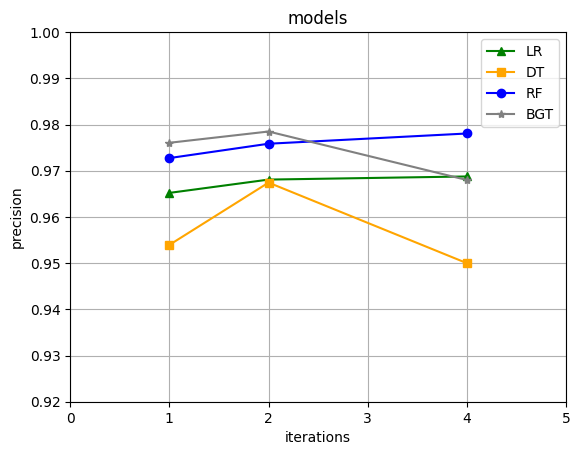

In [87]:
import matplotlib.pyplot as plt

def draw_three_linegraph(x,y1,y2,y3,y4,x_begin,x_end,y_begin,y_end):
    # 创建折线图
    plt.plot(x, y1, label='LR', color='green', marker='^')
    plt.plot(x, y2, label='DT', color='orange', marker='s')
    plt.plot(x, y3, label='RF', color='blue', marker='o')
    plt.plot(x, y4, label='BGT', color='grey', marker='*')

    # 设置图表标题和轴标签
    plt.title('models')
    plt.xlabel('iterations')
    plt.ylabel('precision')

    # 设置图例
    plt.legend()

    # 设置坐标轴范围
    plt.xlim(x_begin, x_end)
    plt.ylim(y_begin, y_end)

    # 显示网格线
    plt.grid(True)

    # 保存图表为图像文件（例如PNG）
    # plt.savefig('house_prices_plot.png')
    # 显示图表
    plt.show()


# 数据
x = [1, 2, 4]
lr = [0.965200467083704, 0.9680814886060151, 0.9687579128424078]
dt = [0.9539436002136693, 0.9674284225382271, 0.9499843297781263]
rf = [0.9727364695346413, 0.9758431391537389, 0.9780573408405818]
gbt = [0.9760455065367686, 0.9784867837025621, 0.9679887751551758]

# 设置x和y的坐标轴范围
x_begin, x_end = 0, 5
y_begin, y_end = 0.92, 1
draw_three_linegraph(x,lr,dt,rf,gbt,x_begin,x_end,y_begin,y_end)


In [ ]:
lr = [0.965200467083704, 0.9680814886060151, 0.9687579128424078]
dt = [0.9539436002136693, 0.9674284225382271, 0.9499843297781263]
rf = [0.9727364695346413, 0.9758431391537389, 0.9780573408405818]
gbt = [0.9760455065367686, 0.9784867837025621, 0.9679887751551758]